In [1]:
import warnings
warnings.filterwarnings("ignore")

print("완료!")

완료!


In [2]:
import tensorflow as tf
print(tf.__version__)

2.6.0


디렉토리 구성하고 데이터를 받아오기

In [3]:
import tensorflow_datasets as tfds

In [4]:
# !mkdir -p ~/aiffel/flowers/FlowerImages

In [5]:
# ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
# print(ds)

# 다른 방식으로 tfds.load()
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/flowers/',
    download=True,
    with_info=True,
    as_supervised=True,
)

In [6]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


이미지 확인(이미지 시각화)

그리고 이미지 크기를 균일하게

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

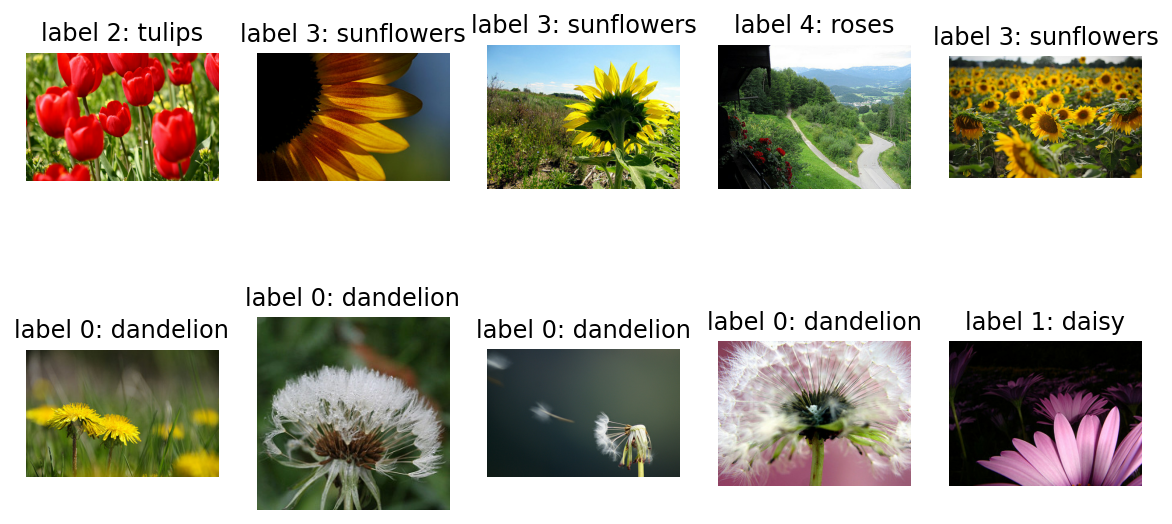

In [8]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [9]:
# 데이터 증강
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.1)
#     image = tf.image.random_contrast(image, lower=0.1, upper=0.3)
    return image, label

augmented_train = raw_train.map(augment_data)

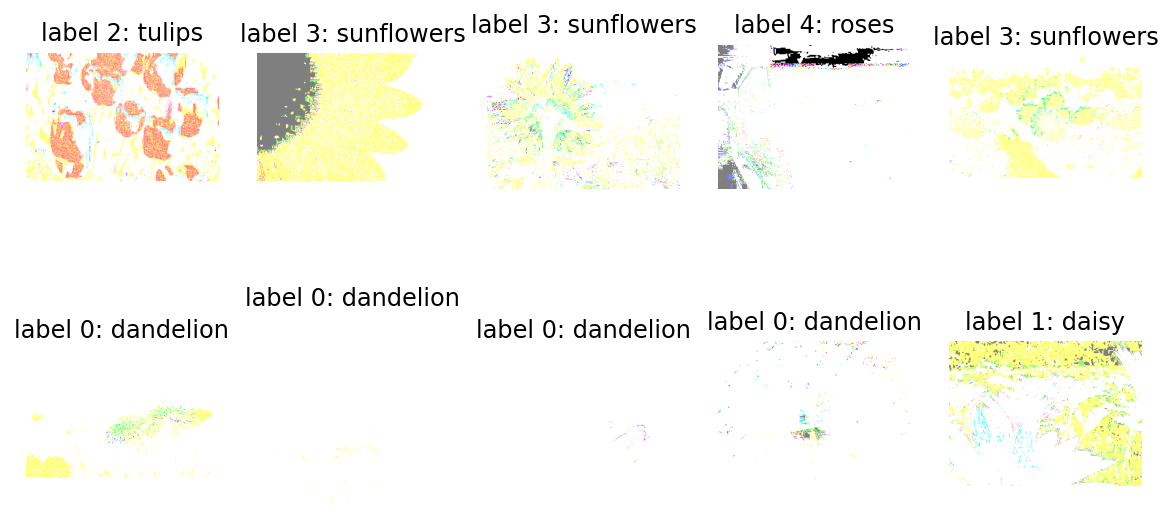

In [10]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(augmented_train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

타입캐스팅

In [11]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [12]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


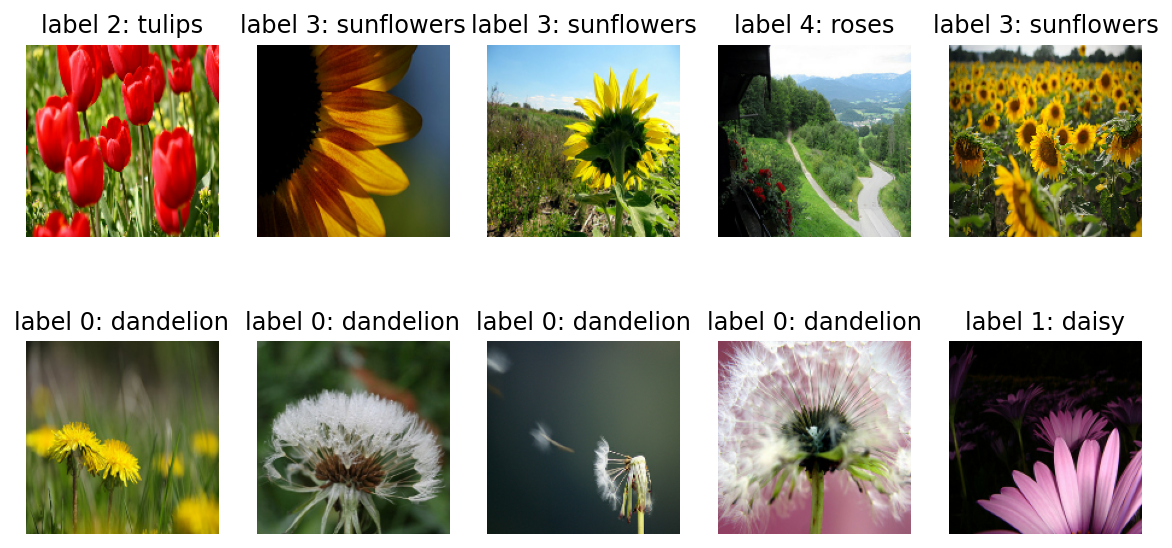

In [13]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 모델링

### 층을 쌓는 모델링

### 전이학습

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

학습

In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [16]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [17]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

베이스모델(초기 모델 = 학습하기 전의 모델) 성능 확인

검증 데이터셋으로 확인해보기

In [18]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [19]:
image_batch.shape

TensorShape([32, 160, 160, 3])

In [20]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [21]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

Flatten 대신 Global Average Pooling

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [23]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [24]:
# dense layer에는 unit과 activation 2개의 매개변수만 사용해주세요.
# unit의 값은 위에서 global_average_layer를 통과했을 때의 값을 생각해보세요.
dense_layer = Dense(units=512, activation='relu')
prediction_layer = Dense(units=5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 5)


Base-model을 학습시킬지 결정하고

In [25]:
base_model.trainable = False

최종 모델 만들기

In [26]:
# 비교: 기존 모델
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [28]:
# 비교: 드롭아웃과 정규화 적용
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'), 
#                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'), 
#                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')#, 
#                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))
])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

In [30]:
base_learning_rate = 0.0001

In [31]:
# 학습률 스케줄링
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [32]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [33]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/20 [=================>............] - ETA: 1s - loss: 1.6409 - accuracy: 0.1526WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 8s 153ms/step - loss: 1.6409 - accuracy: 0.1526
initial loss: 1.64
initial accuracy: 0.15


In [34]:
EPOCHS = 50 # 에포크 늘리고,
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    # 콜백 적용
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                    validation_data=validation_batches)

Epoch 1/50
92/92 [==============================] - 13s 115ms/step - loss: 1.5661 - accuracy: 0.3021 - val_loss: 1.2946 - val_accuracy: 0.5668
Epoch 2/50
92/92 [==============================] - 8s 79ms/step - loss: 1.3186 - accuracy: 0.4653 - val_loss: 1.0568 - val_accuracy: 0.7003
Epoch 3/50
92/92 [==============================] - 8s 79ms/step - loss: 1.1015 - accuracy: 0.5855 - val_loss: 0.8740 - val_accuracy: 0.6975
Epoch 4/50
92/92 [==============================] - 8s 80ms/step - loss: 0.9864 - accuracy: 0.6240 - val_loss: 0.7722 - val_accuracy: 0.7166
Epoch 5/50
92/92 [==============================] - 8s 81ms/step - loss: 0.8745 - accuracy: 0.6706 - val_loss: 0.6875 - val_accuracy: 0.7439
Epoch 6/50
92/92 [==============================] - 8s 82ms/step - loss: 0.8002 - accuracy: 0.7033 - val_loss: 0.6550 - val_accuracy: 0.7575
Epoch 7/50
92/92 [==============================] - 8s 83ms/step - loss: 0.7514 - accuracy: 0.7292 - val_loss: 0.6259 - val_accuracy: 0.7602
Epoch 8/50


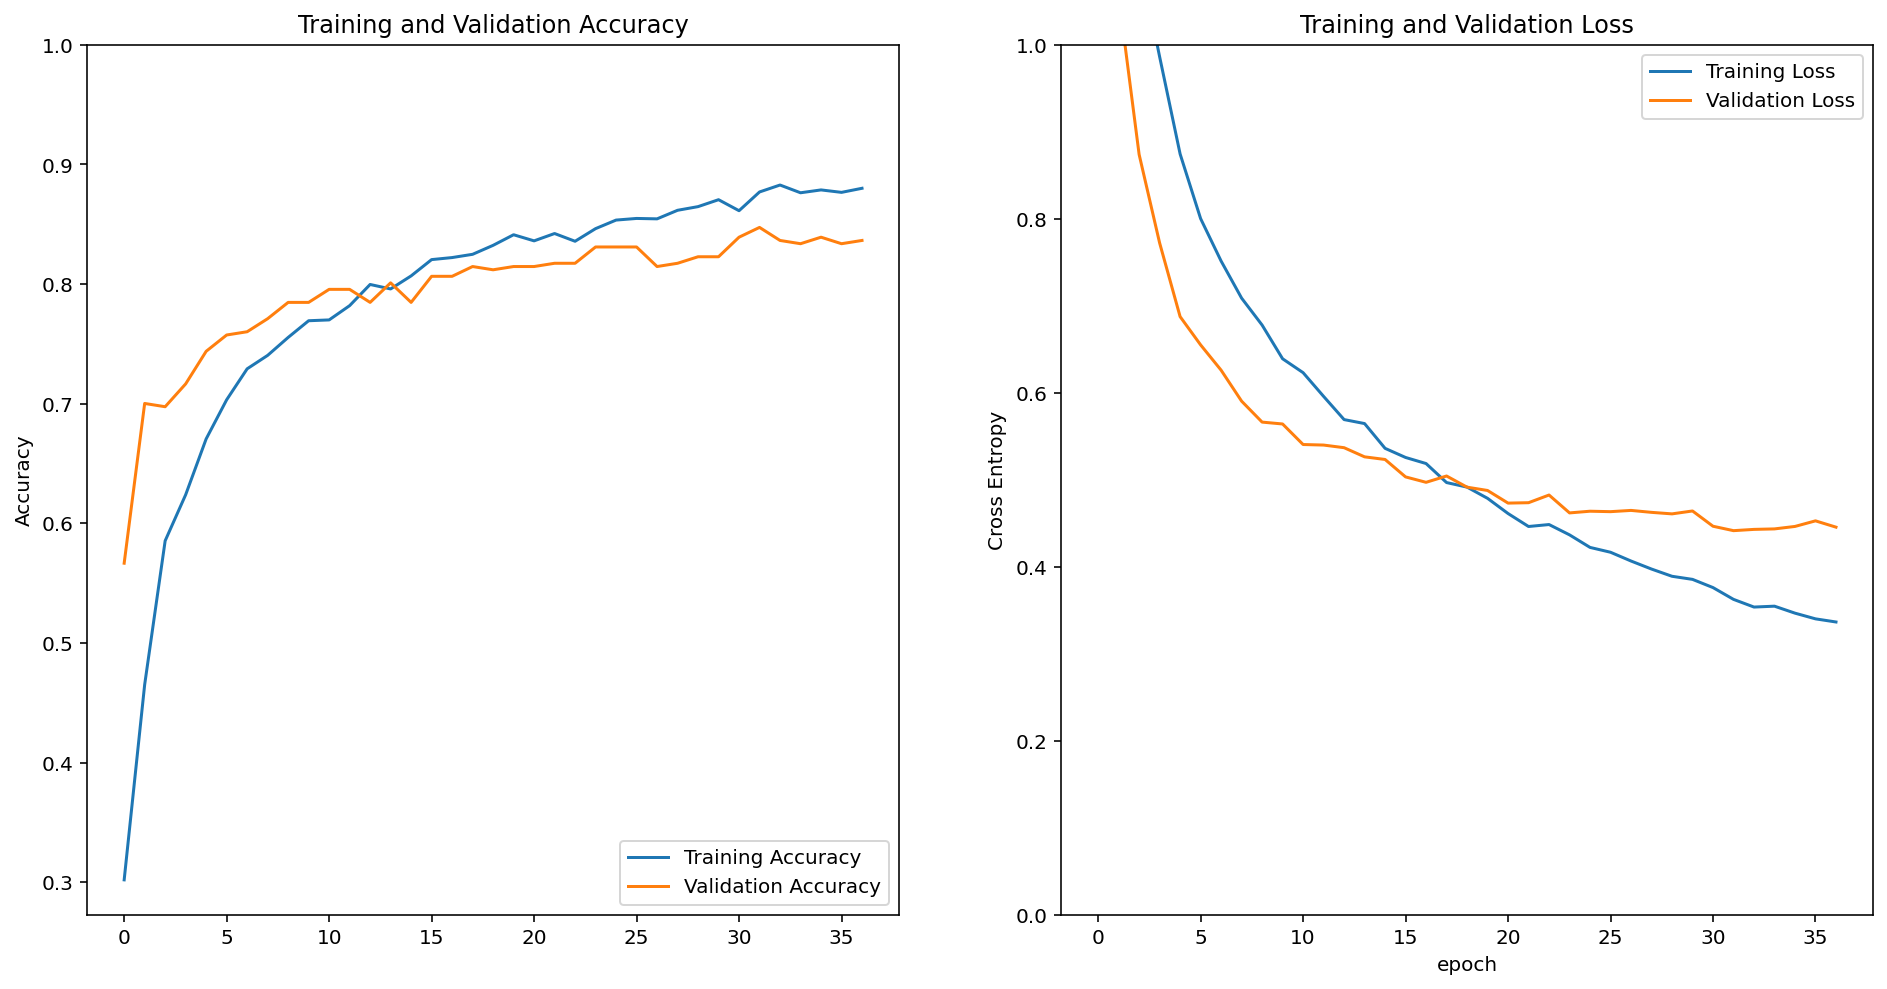

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[6.81916066e-03, 1.73835810e-02, 8.67475867e-01, 6.92693936e-03,
        1.01394504e-01],
       [9.99994516e-01, 5.12136012e-06, 3.32371179e-08, 1.14967932e-07,
        2.53997001e-07],
       [8.22558045e-01, 9.90756676e-02, 7.56570371e-03, 5.67336492e-02,
        1.40670147e-02],
       [2.13928259e-04, 6.19345519e-04, 6.63292348e-01, 2.54510698e-04,
        3.35619837e-01],
       [7.42795587e-01, 2.39843160e-01, 4.06140508e-03, 4.45293449e-03,
        8.84696841e-03],
       [9.88083422e-01, 8.90868809e-03, 4.81794996e-04, 2.35915603e-03,
        1.66920523e-04],
       [5.12186904e-04, 3.72013514e-04, 9.88098323e-01, 3.62897129e-03,
        7.38845859e-03],
       [4.49450642e-01, 5.09973526e-01, 5.14676678e-04, 3.89053561e-02,
        1.15580205e-03],
       [1.97673566e-03, 4.66007594e-04, 8.06776155e-03, 9.64346051e-01,
        2.51434632e-02],
       [9.99989748e-01, 9.88376632e-06, 3.80072827e-08, 2.22244594e-07,
        1.03121771e-07],
       [9.92794931e-01, 6.4134

In [37]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 3, 2, 4, 4, 3, 0, 4])

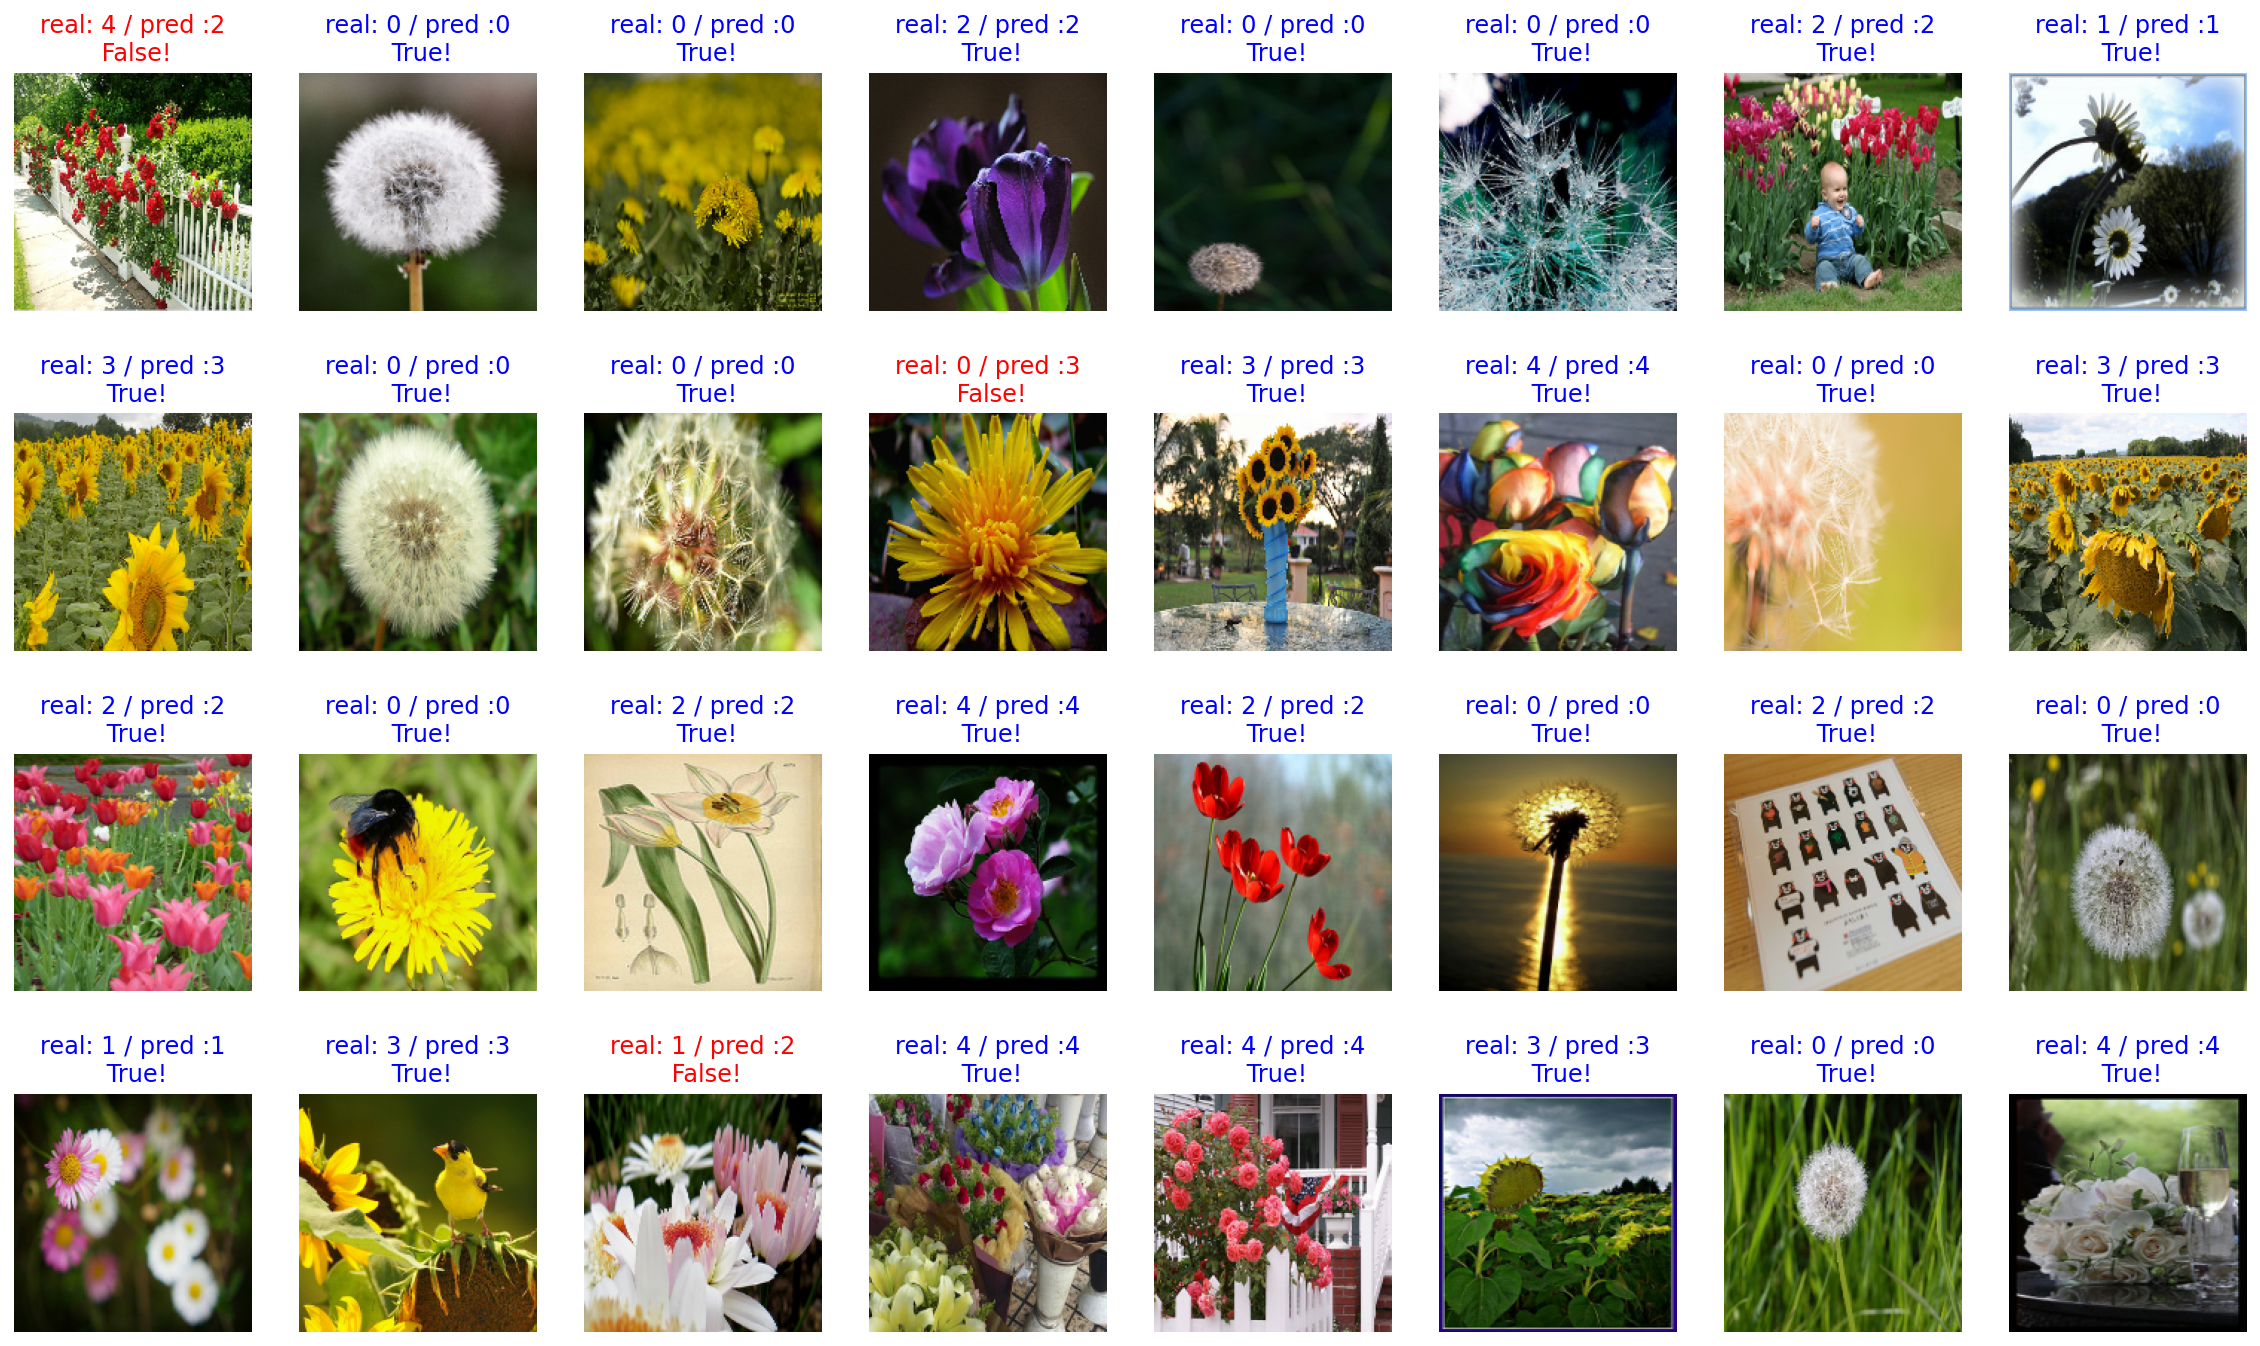

In [38]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [39]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

90.625


모델 Save하고 다시 사용하는 방법

In [40]:
!mkdir -p ~/aiffel/flowers/checkpoint
!mkdir -p ~/aiffel/flowers/images

In [41]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/flowers/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


원하는 이미지를 저장해서 모델 예측 결과를 실습

In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [44]:
IMG_SIZE = 160
img_dir_path = os.getenv("HOME") + "/aiffel/flowers/images"
test_image_path = os.path.join(img_dir_path, 'flowers_dandelion1.jpg')

test_image = load_img(test_image_path, target_size=(IMG_SIZE, IMG_SIZE))
test_image

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/flowers/images/dandelion.jpg'

In [ ]:
flower_Dan_image = img_to_array(dog_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
flower_Dan_image.shape

In [ ]:
prediction = model.predict(dog_image)
prediction

In [ ]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
#     dandelion_percentage = round(prediction[0] * 100)
#     daisy_percentage = round(prediction[1] * 100)
#     tulip_percentage = round(prediction[2] * 100)
#     sunflower_percentage = round(prediction[3] * 100)
#     rose_percentage = round(prediction[4] * 100)
    
# flowers = [
#     ("Dandelion", dandelion_percentage),
#     ("Cosmos", cosmos_percentage),
#     ("Tulip", tulip_percentage),
#     ("Sunflower", sunflower_percentage),
#     ("Rose", rose_percentage)
# ]

flower_names = ["민들레", "데이지", "튤립", "해바라기", "장미"]
percentages = [round(p * 100) for p in prediction]
flowers = list(zip(flower_names, percentages))

# 가장 큰 퍼센트 값을 가진 꽃을 선택
max_flower = max(flowers, key=lambda x: x[1])

# 결과 출력
print(f"사진 속 꽃은 {max_flower[1]}% {max_flower[0]}입니다.")

In [ ]:
filename = 'flower_dandelion.jpg'

show_and_predict_image(img_dir_path, filename)

In [ ]:
filename = 'flower_daisy.jpg'

show_and_predict_image(img_dir_path, filename)

In [ ]:
filename = 'flower_tulip.jpg'
show_and_predict_image(img_dir_path, filename)

In [ ]:
filename = 'flower_sunflower.jpg'
show_and_predict_image(img_dir_path, filename)

In [ ]:
filename = 'flower_rose.jpg'
show_and_predict_image(img_dir_path, filename)